In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the datasets

In [10]:
movies = pd.read_csv('../data/raw/movie.csv')
ratings = pd.read_csv('../data/raw/rating.csv')
tags = pd.read_csv('../data/raw/tag.csv')
links = pd.read_csv('../data/raw/link.csv')

In [15]:
print(movies.head())
print(ratings.head())
print(tags.head())
print(links.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40
   userId  movieId            tag            timestamp
0      18     4141    Mark Waters  2009-04-24 18:19:40
1      

In [17]:
# movies.csv: Movie metadata (movieId, title, genres)
# ratings.csv: User ratings (userId, movieId, rating, timestamp)
# tags.csv: User-generated tags for movies
# links.csv: External identifiers (IMDb IDs)

In [18]:
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
None


In [19]:
print(ratings.describe())

             userId       movieId        rating
count  2.000026e+07  2.000026e+07  2.000026e+07
mean   6.904587e+04  9.041567e+03  3.525529e+00
std    4.003863e+04  1.978948e+04  1.051989e+00
min    1.000000e+00  1.000000e+00  5.000000e-01
25%    3.439500e+04  9.020000e+02  3.000000e+00
50%    6.914100e+04  2.167000e+03  3.500000e+00
75%    1.036370e+05  4.770000e+03  4.000000e+00
max    1.384930e+05  1.312620e+05  5.000000e+00


In [20]:
# Unique counts

In [21]:
print(f"Number of unique users: {ratings['userId'].nunique()}")
print(f"Number of unique movies: {movies['movieId'].nunique()}")

Number of unique users: 138493
Number of unique movies: 27278


C:\Users\jmalo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


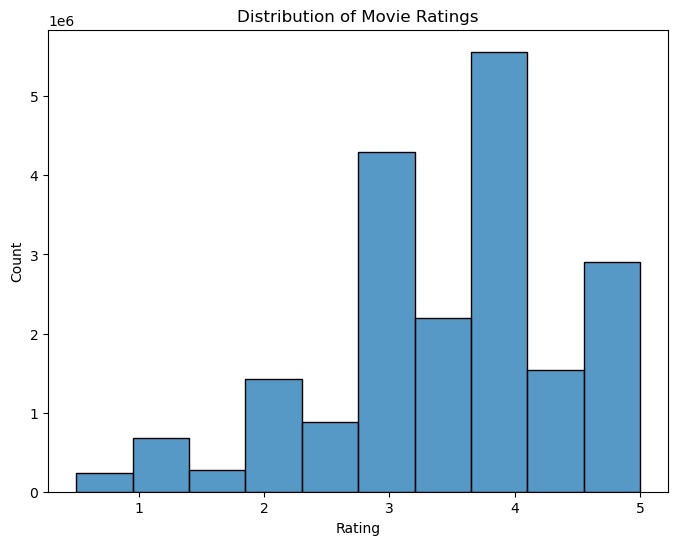

In [25]:
# Plot distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(ratings['rating'], bins=10, kde=False)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [26]:
# Find most popular movies

In [27]:
# count of ratings per movie
movie_ratings_count = ratings.groupby('movieId')['rating'].count().reset_index()
movie_ratings_count.columns = ['movieId', 'rating_count']

In [28]:
# merge with movie titles
popular_movies = movie_ratings_count.merge(movies, on='movieId')
popular_movies = popular_movies.sort_values(by='rating_count', ascending=False)

In [29]:
# display top 10 rated movies
print(popular_movies.head(10))

      movieId  rating_count                                      title  \
293       296         67310                        Pulp Fiction (1994)   
352       356         66172                        Forrest Gump (1994)   
315       318         63366           Shawshank Redemption, The (1994)   
587       593         63299           Silence of the Lambs, The (1991)   
476       480         59715                       Jurassic Park (1993)   
257       260         54502  Star Wars: Episode IV - A New Hope (1977)   
108       110         53769                          Braveheart (1995)   
583       589         52244          Terminator 2: Judgment Day (1991)   
2486     2571         51334                         Matrix, The (1999)   
523       527         50054                    Schindler's List (1993)   

                                genres  
293        Comedy|Crime|Drama|Thriller  
352           Comedy|Drama|Romance|War  
315                        Crime|Drama  
587              Crim